# When will the UK Population be Fully Vaccinated Against Covid-19?



Basics of Covid-19 vaccines:
- when first vaccine given
- 2 doses (space between)
- AstraZeneca and Pfizer
- priority groups

## Setup

In [34]:
# Get data from the internet
import requests
import json

# Analyse data and dates
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualisations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use("seaborn-notebook")
fontsize = 14
plt.rc('font', size=fontsize)
plt.rc('axes', titlesize=fontsize)
plt.rc('axes', labelsize=fontsize)
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize)
width = 12
height = 5
figsize = (width, height)
%matplotlib inline

## Getting the data

The government has developed a Coronavirus dashboard which is updated daily with key statistics including the number of Covid-19 tests, cases, hospitalisations, deaths and vaccinations. You can view the dashboard here: https://coronavirus.data.gov.uk/

All of the source data can be downloaded, for example as a spreadsheet, by clicking the "download" button under each table or graph. Even better for our purposes is that the dashboard has an "Application Programming Interface" (API), which we can use to extract precisely the data we're interested in programmatically from this notebook!

The documentation for the API is found under the ["Developer's Guide" section](https://coronavirus.data.gov.uk/details/developers-guide) of the dashboard, which describes the various parameters that are available and how they should be configured. In particular, there are Python examples which show us how to structure a data query. There are three main steps, as follows:

**Step 1:** Defining the geographical region we are interested in. Some of the data is available regionally as well as nationally. The number of positive cases, for example, is available both for the UK as a whole but also down to "local authority" level (local council areas, of which there are over 300 in England alone). However, the vaccination data we're interested in is only available as summary totals for the whole UK (although this is perfect for our purposes).

In the API, to define that we wish to retrieve summary data for the whole UK we must set the `areaType` parameter to be the value "overview", as follows:

In [3]:
filters = "areaType=overview"

If for a different analysis we wanted data for a smaller area we would need to define two parameters separated by semi-colons, such as `areaType=nation;areaName=england` to get data for England only.

**Step 2:** Defining which statistics (data columns) we wish to retrieve. To explore the status of the vaccination programme we would like to know the number of new first and second vaccine doses administered on each day, and the overall (cumulative) total of first and second doses administered up to and including each day.

In the API these fields are given long names like `newPeopleVaccinatedFirstDoseByPublishDate`. Finding the correct names for the data you're interested can be a bit tricky. Most are listed in the documentation but not all - the vaccination data has been added fairly recently and isn't documented, for example. Usually the field names for the API match the column names in files downloaded from the web-site (using the "download" buttons), so you can do some super sleuthing and find them that way if you'd like to try an analysis with different data!

As the names are long the API helpfully let's us rename them to something more convenient in the dictionary format seen below. Finally, to pass this dictionary to the API it must be converted into a string without any spaces, which we achieve using the `json.dumps` function.

In [57]:
# define which data columns we wish to retrieve, and what to call them
structure = {
    "date": "date",
    "newFirst": "newPeopleVaccinatedFirstDoseByPublishDate",
    "cumFirst": "cumPeopleVaccinatedFirstDoseByPublishDate",
    "newSecond": "newPeopleVaccinatedSecondDoseByPublishDate",
    "cumSecond": "cumPeopleVaccinatedSecondDoseByPublishDate",
}

# convert the dictionary into a string without spaces (using the separators argument)
structure = json.dumps(structure, separators=(",", ":"))

**Step 3:** Submitting the API query. We can now package our parameters up into the structure required by the API, and  send our query using the `requests.get` function. If the query is successful we should seee a status code of 200 ([as per the convention for request status codes](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status#successful_responses)). If not it should also come back with a useful error message to diagnose the problem with our query.

In [51]:
# query the API for the data
ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"

api_params = {
    "filters": filters,
    "structure": structure
}
response = requests.get(ENDPOINT, params=api_params, timeout=10)

if response.status_code != 200:
    raise RuntimeError(f'Request failed: { response.text }')

Our query was successful but where is the data? We can convert the data the request contains into a Python function using the `.json()` method on the response, and then look at what fields are contained in the data (the keys of the dictionary):

In [4]:
j = response.json()
print(j.keys())

dict_keys(['length', 'maxPageLimit', 'data', 'pagination'])


This doesn't look like the vaccination data we're expecting yet. The response also includes metadata about our query, in particular whether we queried too much data to return in one go. If the "length" of our query was larger than the  "maxPageLimit" we'd have to split our query into multiple queries.

In [5]:
print(j["length"], j["maxPageLimit"])

89 2500


In this case we are a long way under the limit so we should have all the data. To find it we can have a look at one of the elements in the "data" list:

In [60]:
print(j["data"][0])

{'date': '2021-04-08', 'newFirst': 96242, 'cumFirst': 31903366, 'newSecond': 449269, 'cumSecond': 6541174}


Each element of the "data" list contains the vaccination data for one day. To make it easier to analyse the data we can convert it to a pandas data frame, using the date as the unique index for the rows (as we have one row for each day). We also take care to properly convert the date string representations into actual Python datetimes, so we can benefit from pandas' features for processing time series data. We also convert the numbers into units of 1 million to make them easier to read in figures and tables later.

In [58]:
df = pd.DataFrame(j["data"])

# use the "date" column to index our data
df.set_index("date", inplace=True)
# convert the date text strings into Python datetimes
df.index = pd.to_datetime(df.index)
# sort the data from oldest to newest
df.sort_index(inplace=True)

# convert all totals to millions
df = df / 1e6

df.tail()

,newFirst,cumFirst,newSecond,cumSecond
date,,,,
2021-04-04,0.048055,31.581623,0.047708,5.432126
2021-04-05,0.040744,31.622367,0.064590,5.496716
2021-04-06,0.085227,31.707594,0.186793,5.683509
2021-04-07,0.099530,31.807124,0.408396,6.091905
2021-04-08,0.096242,31.903366,0.449269,6.541174


Our query above gets all the data up to the current date. To ensure re-running the notebook reproduces the same results from the time of writing only data up to the XXX of April should be included, which is done using the `run_as_date` variable below. If you'd like to see the latest results instead you can change the value to today's date.

In [2]:
# To reproduce the results at the time of publishing the story set the date below to
# 13th April 2021 (run_as_date = datetime(2021, 4, 13)), or use today's date to update
# the results with the latest available data (run_as_date = datetime.now()).
run_as_date = datetime.now()

# filter the data to only include dates up to the run_as_date
df = df[df.index < run_as_date]


## Vaccines so far

In [8]:
# no. people getting vaccinations (in millions)
# https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/951928/uk-covid-19-vaccines-delivery-plan-final.pdf
priority_totals = {
    "Groups 1-4": 15,
    "Groups 1-9": 32,
    "All Adults": 53
}


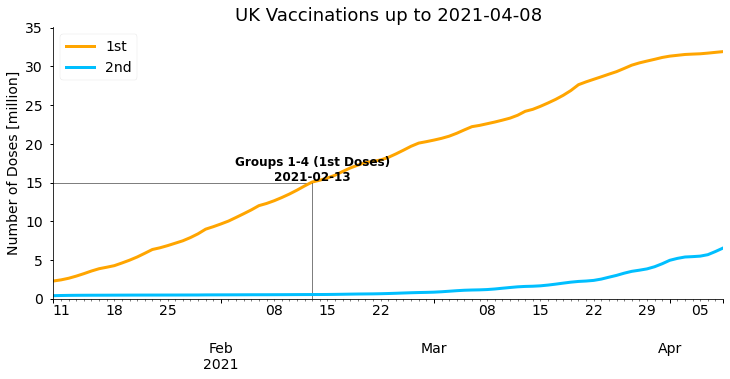

In [9]:
def plot_cumulative_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot cumulative first and second doses, and the dates when
    the vaccination of prioriy groups completed.
    Optionally distinguish actual data and forecasted data. Data
    after forecast_date will be displayed with a dashed line.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    max_y = df["cumFirst"].max() * 1.1  # y-axis limit
    ax.set_ylim([0, max_y])
    text_offset = 1.02
    columns = ["cumFirst", "cumSecond"]
    labels = ["1st", "2nd"]
    colors = ["orange", "deepskyblue"]

    if forecast_date is None:
        forecast_date = df.index.max() + timedelta(days=1)
        plot_forecast = False
    else:
        plot_forecast = True
    
    for col, clr, lab in zip(columns, colors, labels):
        # plot actual data with a solid line
        df[col][
            df[col].index <= forecast_date  # select rows of actual data 
        ].plot(color=clr, label=lab, linewidth=3)

        # plot forecast data with a dashed line
        if plot_forecast:
            df[col][
                df[col].index >= forecast_date  # select rows of forecasted data 
            ].plot(color=clr, linestyle="--", label=f"{lab} (Forecast)")

        # label priority group completion dates
        max_col = df[col].max()
        for name, pop in priority_totals.items():
            if max_col >= (pop - 1e-7):  # vaccines completed for this group
                complete_date = df[df[col] >= (pop - 1e-7)].iloc[0].name

                ax.hlines(pop, 0, complete_date , color="k",linewidth=0.5)
                ax.axvline(complete_date, ymax=pop/max_y, color="k",linewidth=0.5)
                ax.text(
                    complete_date,
                    pop*text_offset,
                    f"{name} ({lab} Doses)\n{complete_date.date()}",
                    ha="center",
                    size=12,
                    fontweight="bold",
                )
            
    ax.legend()
    ax.set_ylabel("Number of Doses [millions]")
    if title is not None:
        ax.set_title(title, fontsize=18)


plot_cumulative_doses(
    df, title=f"UK Vaccinations up to {df.index.date.max()}"
)

In [10]:
df["newTot"] = df["newFirst"] + df["newSecond"]
df["cumTot"] = df["cumFirst"] + df["cumSecond"]


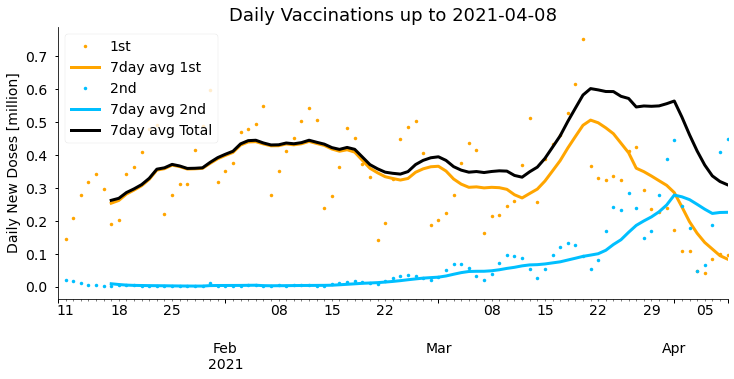

In [11]:
def plot_daily_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot daily first and second doses, the sum of 1st and 2nd doses,
    and their weekly rolling averages.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    columns = ["newFirst", "newSecond", "newTot"]
    labels = ["1st", "2nd", "Total"]
    colors = ["orange", "deepskyblue", "k"]
    show_daily = [True, True, False]

    n_avg = 7
    roll_avg = df.rolling(window=n_avg).mean()


    if forecast_date is None:
        forecast_date = df.index.max() + timedelta(days=1)
        plot_forecast = False
    else:
        plot_forecast = True
    
    for col, clr, lab, daily in zip(columns, colors, labels, show_daily):
        if daily:
            df[col].plot(color=clr, linestyle="None", marker=".", label=lab, ax=ax)

        # plot actual rolling average data with a solid line
        roll_avg[col][
            roll_avg[col].index <= forecast_date  # select rows of actual data 
        ].plot(color=clr, label=f"7day avg {lab}", linewidth=3)

        # plot forecast rolling average data with a dashed line
        if plot_forecast:
            roll_avg[col][
                roll_avg[col].index >= forecast_date  # select rows of forecasted data 
            ].plot(color=clr, linestyle="--", label=f"7day avg {lab} (Forecast)")
            
    ax.legend()
    ax.set_ylabel("Daily New Doses [millions]")
    if title is not None:
        ax.set_title(title, fontsize=18)


plot_daily_doses(
    df, title=f"Daily Vaccinations up to {df.index.date.max()}"
)

Text(0, 0.5, 'Daily Doses (1st + 2nd) [million]')

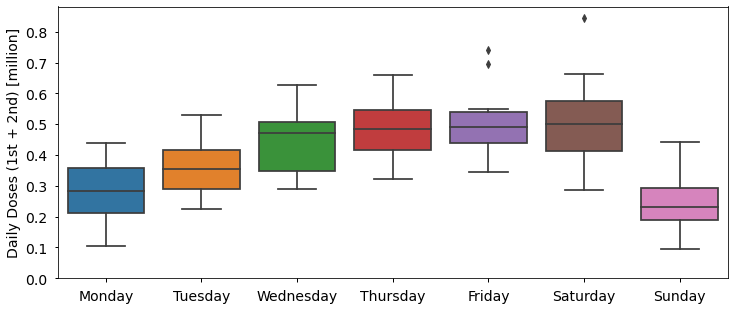

In [12]:
df["weekday"] = df.index.day_name()

plt.figure(figsize=figsize)
sns.boxplot(
    x="weekday", y="newTot", data=df,
    order=[
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday",
        "Sunday"
    ]
)
plt.xlabel("")
plt.ylim([0, plt.ylim()[1]])
plt.ylabel("Daily Doses (1st + 2nd) [millions]")

## When are 2nd doses being given?

days after 1st dose that 2nd dose given

3 to 12 weeks: https://www.gov.uk/government/publications/covid-19-vaccination-what-to-expect-after-vaccination/what-to-expect-after-your-covid-19-vaccination#what-to-do-next


In [13]:
for date_1st, row in df.iterrows():
    if row["cumFirst"] > df["cumSecond"].max():
        # reached the people who haven't been given the 2nd dose yet
        print(
            "1st doses from", (date_1st - timedelta(days=1)).date(),
            "were completed", delay, "days later, on", date_2nd.date()
        )
        break

    # find the earliest date where 2nd doses matched/exceded 1st
    # doses on this date
    date_2nd = df[df["cumSecond"] >= row["cumFirst"]].index.min()
    
    # calculate and save how many days it was until 2nd doses were given
    delay = (date_2nd - date_1st).days
    df.loc[date_1st, "delaySecond"] = delay
    

df["delaySecond"].describe()

1st doses from 2021-01-23 were completed 75 days later, on 2021-04-08


count    14.000000
mean     72.142857
std       1.350621
min      71.000000
25%      71.000000
50%      72.000000
75%      72.000000
max      75.000000
Name: delaySecond, dtype: float64

In [14]:
second_dose_days = df["delaySecond"].dropna()[-1]
print("We will assume second doses are given", second_dose_days, "days later.")

We will assume second doses are given 75.0 days later.


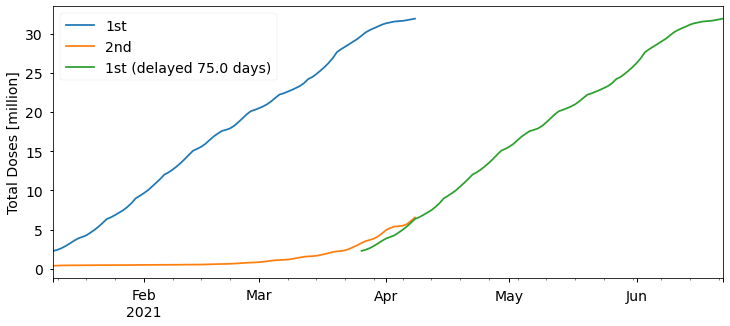

In [15]:
delayed_1st = df["cumFirst"].copy()
delayed_1st.index = delayed_1st.index + timedelta(days=second_dose_days)

plt.figure(figsize=figsize)
df["cumFirst"].plot(label="1st")
df["cumSecond"].plot(label="2nd")
delayed_1st.plot(label=f"1st (delayed {second_dose_days} days)")
plt.ylabel("Total Doses [millions]")
plt.legend()


## Forecasting Future Vaccinations

In [16]:
def lookback(df, date, days=7):
    return df.loc[date - timedelta(days=days), "newTot"]


def forecast_vaccines(
    df,
    second_dose_days,
    forecast_fn=lookback,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1)
):
    """
    Forecast vaccines assumming doses continue to be given at the
    same rate as the last week (or n_avg days) in the available data.

    df: DataFrame of actual vaccine data.
    second_dose_days: Days after 1st dose that 2nd dose is given.
    n_avg: Assume total doses today will be the same as total doses n_avg days ago.
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    """
    # extend our time series index to the future
    first_data = df.index.min()
    last_data = df.index.max()
    df = df.append(pd.DataFrame(index=pd.date_range(last_data, end_date, closed="right")))
    df.sort_index(inplace=True)

    future_dates = pd.date_range(start=last_data + timedelta(days=1), end=end_date)
    for d in future_dates:
        if d - timedelta(days=second_dose_days) < first_data:
            # no 1st dose data second_dose_days ago, assume no 2nd doses required
            pending_2nd_doses = 0
        else:
            # no. second doses needed today is difference between total
            # 2nd doses so far and 1st doses second_dose_days ago (who
            # now require 2nd dose)
            dose2_req = df.loc[
                d - timedelta(days=second_dose_days), "cumFirst"
            ]
            dose2_sofar =  df.loc[
                d - timedelta(days=1), "cumSecond"
            ]
            pending_2nd_doses = max([0, dose2_req - dose2_sofar])

        # forecast to give same total doses today as n_avg days ago
        total_doses_today = forecast_fn(df, d)
        if total_doses_today + df.loc[d - timedelta(days=1), "cumTot"] > 2 * uk_pop:
            # but don't vaccinate more than the total population
            total_doses_today = 2 * uk_pop - df.loc[d - timedelta(days=1), "cumTot"]
        df.loc[d, "newTot"] = total_doses_today

        # prioritise 2nd doses over 1st doses - give all 2nd doses required (or as
        # many as possible if the number required is more than the total doses available)
        dose2_today = min(pending_2nd_doses, total_doses_today)
        df.loc[d, "newSecond"] = dose2_today
        df.loc[d, "cumSecond"] = df.loc[d - timedelta(days=1), "cumSecond"] + df.loc[d, "newSecond"]

        # remaining vaccines given as new 1st doses
        dose1_remaining = uk_pop - df.loc[d - timedelta(days=1), "cumFirst"]
        dose1_today = min(total_doses_today - dose2_today, dose1_remaining)
        df.loc[d, "newFirst"] = dose1_today
        df.loc[d, "cumFirst"] = df.loc[d - timedelta(days=1), "cumFirst"] + df.loc[d, "newFirst"]

        df.loc[d, "cumTot"] = df.loc[d, "cumFirst"] + df.loc[d, "cumSecond"]
        
    return df


df_forecast = forecast_vaccines(df, second_dose_days)

Text(0, 0.5, 'Total Doses [million]')

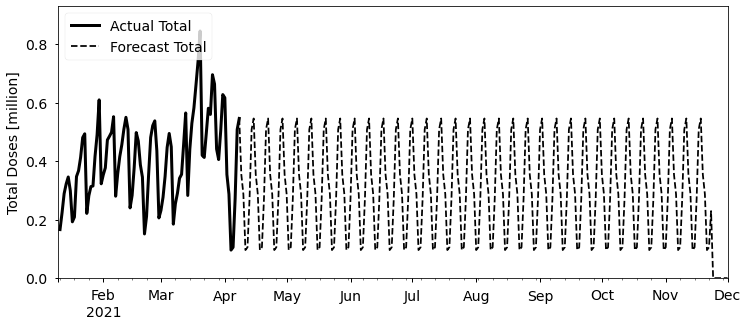

In [17]:
plt.figure(figsize=figsize)

total = df_forecast["newTot"]
last_data = df.index.max()
total[total.index <= last_data].plot(color="k", label="Actual Total", linewidth=3)
total[total.index >= last_data].plot(color="k", linestyle="--", label="Forecast Total")

plt.legend(loc="upper left")
plt.ylim([0, 1.1 * total.max()])
plt.ylabel("Total Doses [millions]")

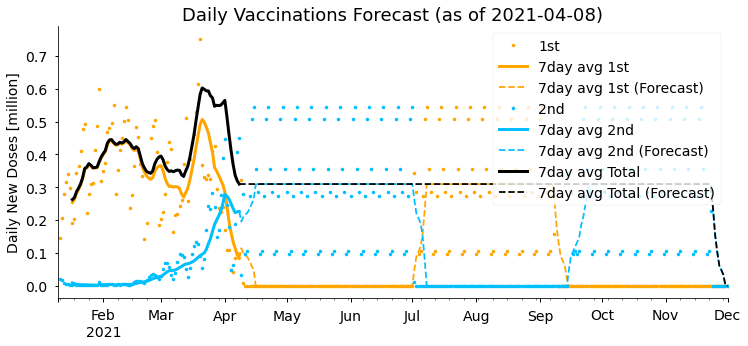

In [18]:
plot_daily_doses(
    df_forecast, forecast_date=last_data,
    title=f"Daily Vaccinations Forecast (as of {df.index.date.max()})"
)

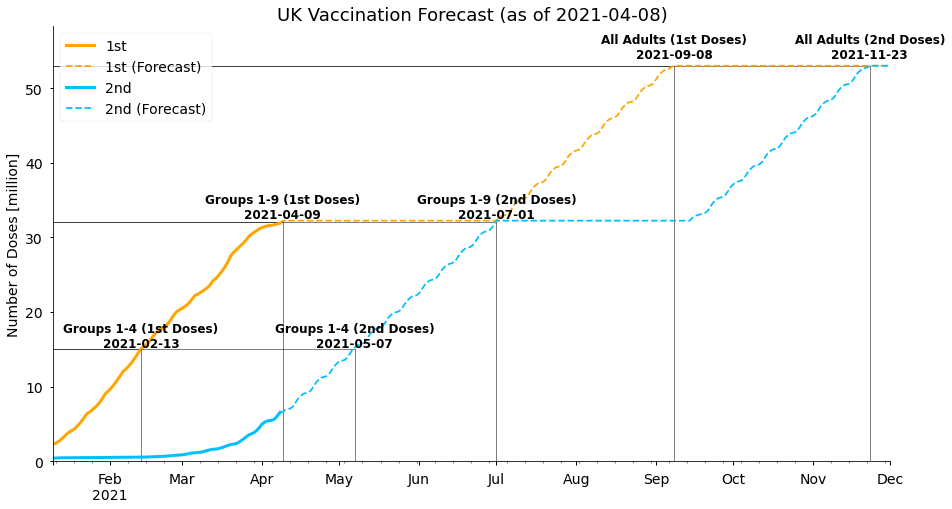

In [19]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8),
    title=f"UK Vaccination Forecast (as of {df.index.date.max()})"
)

## Uncertainty in Our Forecast

In [24]:
weekly_avg = df["newTot"].resample("W", label="left").mean()
# label="left" uses week start dates to label our averages, rather
# than week end dates (which is the default)

Text(0.5, 0, 'Mean Daily Doses [million]')

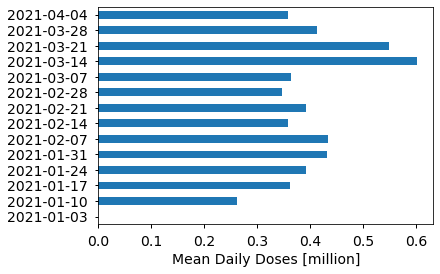

In [25]:
# only keep the date (not time) to tidy up axis labels
weekly_avg.index = weekly_avg.index.date

weekly_avg.plot.barh()
plt.xlabel("Mean Daily Doses [millions]")

In [26]:
weekly_avg.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9])

0.10    0.349097
0.25    0.358341
0.50    0.391872
0.75    0.430859
0.90    0.526194
Name: newTot, dtype: float64

In [27]:
def forecast_const(
    df,
    second_dose_days,
    daily_doses,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1)
):
    """
    Forecast vaccines assumming daily_doses doses are given per day.

    df: DataFrame of actual vaccine data.
    first_data: Earliest date we have data for
    last_data: Latest date we have data for.
    second_dose_days: Days after 1st dose that 2nd dose is given.
    daily_doses: No. of doses to give per day
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    """
    def const_doses(df, date):
        return daily_doses
    
    df_forecast = forecast_vaccines(
        df,
        second_dose_days,
        forecast_fn=const_doses,
        uk_pop=uk_pop, 
        end_date=end_date,
    )

    return df_forecast


In [28]:
quantiles = [0.1, 0.25, 0.75, 0.9]
forecast_q = {}
daily_doses_q = {}

for q in quantiles:
    daily_doses_q[q] = weekly_avg.quantile(q=q)
    forecast_q[q] = forecast_const(
        df,
        second_dose_days,
        daily_doses_q[q],
        uk_pop=priority_totals["All Adults"], 
    )


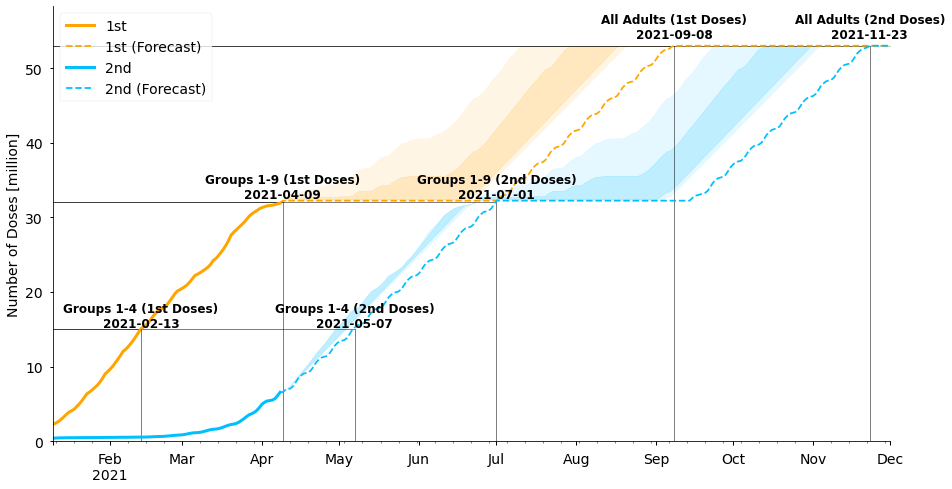

In [29]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8), 
)

q_fill = [
    # start quantile, end quantile, fill opacity (alpha)
    (0.1, 0.25, 0.1),
    (0.25, 0.75, 0.25),
    (0.75, 0.9, 0.1)
]
columns = [
    # column name, column colour
    ("cumFirst", "orange"),
    ("cumSecond", "deepskyblue")
]
for q_start, q_end, alpha in q_fill:
    for col, clr in columns:
        plt.fill_between(
            forecast_q[q_start].index,
            forecast_q[q_start][col],
            forecast_q[q_end][col],
            color=clr,
            alpha=alpha,
        )


## Government Targets and SAGE Vaccine Rollout Estimates

The government has the target of all UK adults being offered the vaccine by the end of July (https://www.bbc.co.uk/news/uk-56141867). This is currently in line with our optimistic forecast above, in which 0.43 million doses are given per day (on average).

Alternatively, the latest modelling from the Scientific Advisory Group for Emergencies (SAGE) (https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/975909/S1182_SPI-M-O_Summary_of_modelling_of_easing_roadmap_step_2_restrictions.pdf) uses the following two scenarios:
- **Fast scenario:** 0.39m doses per day in England until week commencing 26th July and 0.29m per day thereafter
- **Slow scenario:** 0.36m doses per week in England until week commencing 26th July and 0.29m per day thereafter


Note that these numbers are for England only, if we scale these up for the whole UK (56 million population England, 67 million population UK) we get:
- **Fast scenario:** 0.46m doses per day until week commencing 26th July and 0.34m per day thereafter
- **Slow scenario:** 0.43m doses per week until week commencing 26th July and 0.34m per day thereafter

SAGE also uses a 11-week (77 day) period between doses, several days longer than the 72 days we derived from the data.

In [30]:
def forecast_sage(
    df,
    second_dose_days,
    scenario="fast",
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1)
):
    """
    Forecast vaccines assumming daily_doses doses are given per day.

    df: DataFrame of actual vaccine data.
    first_data: Earliest date we have data for
    last_data: Latest date we have data for.
    second_dose_days: Days after 1st dose that 2nd dose is given.
    daily_doses: No. of doses to give per day
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    """
    if not (scenario == "fast" or scenario == "slow"):
        raise ValueError("scenario must be 'fast' or 'slow'")
    
    def sage_doses(df, date, scenario=scenario):
        if date > datetime(2021, 8, 1):
            return 0.34
        else:
            if scenario == "fast":
                return 0.46
            else:
                return 0.43

    df_forecast = forecast_vaccines(
        df,
        second_dose_days,
        forecast_fn=sage_doses,
        uk_pop=uk_pop, 
        end_date=end_date,
    )

    return df_forecast


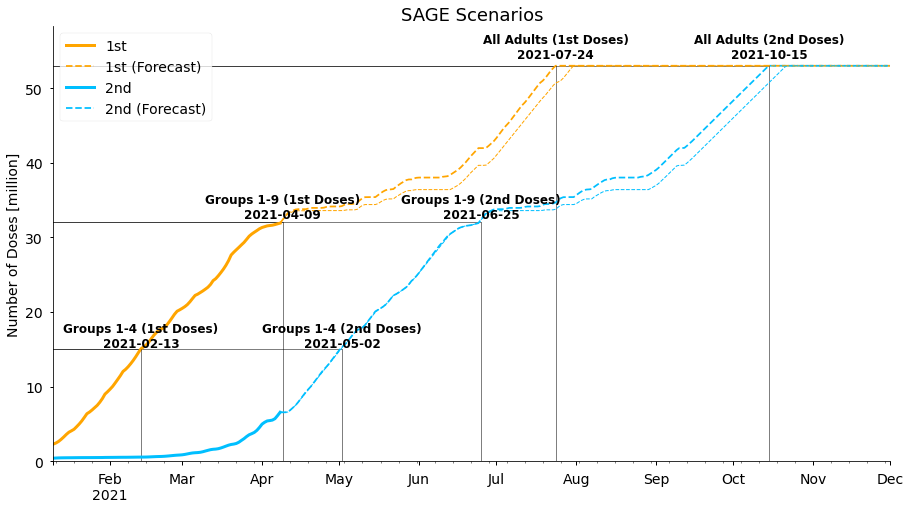

In [31]:
sage_2nd_delay = 77 # 11 weeks until 2nd dose
df_sage_fast = forecast_sage(
    df,
    sage_2nd_delay,  
    scenario="fast",
)
df_sage_slow = forecast_sage(
    df,
    sage_2nd_delay,  # 11 weeks until 2nd dose
    scenario="slow",
)

plot_cumulative_doses(
    df_sage_fast, forecast_date=last_data, figsize=(15, 8),
    title=f"SAGE Scenarios"
)

plt.plot(
    df_sage_slow["cumFirst"],
    color="orange", linestyle="--", linewidth=1
)
plt.plot(
    df_sage_slow["cumSecond"],
    color="deepskyblue", linestyle="--", linewidth=1
)


## Summary

Limitations:
- new vaccines (can't be used for 2nd doses initially)
- single dose vaccines

# BACKUP

## Stability of Forecasts

**SHOULD RECALCULATE second_dose_days FOR EACH FORECAST**

In [20]:
def run_forecasts(
    df,
    run_start,
    second_dose_days,
    n_avg=7,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2022, 3, 1)
):
    """
    Calculate the completion date of the UK vaccination programme
    with different forecast start dates. A forecast is run as if
    it was every day starting from the date run_start, up to the
    date of the latest available data.
    """
    forecast_start_dates = pd.date_range(    
        start=run_start, end=df.index.max()
    )
    completion_dates = pd.Series(index=forecast_start_dates, dtype=float)
    for forecast_start in forecast_start_dates:
        df_forecast = forecast_vaccines(
            df[df.index <= forecast_start],
            second_dose_days,
            uk_pop=uk_pop, 
            end_date=end_date
        )
        if df_forecast["cumSecond"].max() >= (uk_pop - 1e-7):
            finish_date = df_forecast[df_forecast["cumSecond"] >= (uk_pop - 1e-7)].iloc[0].name
            completion_dates.loc[forecast_start] = finish_date
        else:
            print(forecast_start.date(), "forecast: Population not vaccinated by ", end_date.date(), "!!!")
            completion_dates.loc[forecast_start] = end_date
    
    return completion_dates

In [21]:
completion_dates = run_forecasts(df, datetime(2021, 2, 1), second_dose_days)

Text(0.5, 0, 'Forecast Date')

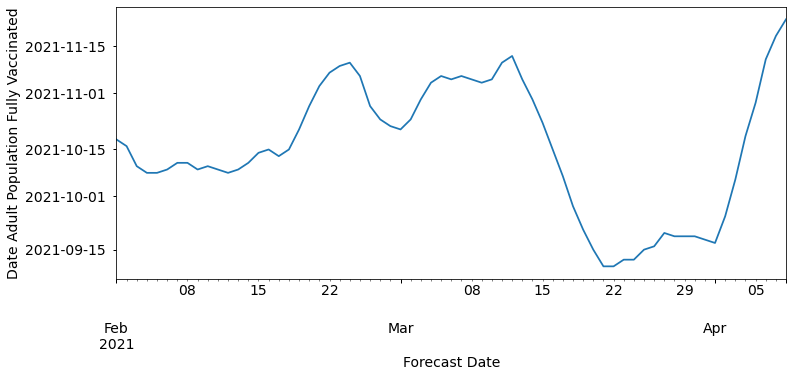

In [22]:
plt.figure(figsize=figsize)
completion_dates.plot()
plt.ylabel("Date Adult Population Fully Vaccinated")
plt.xlabel("Forecast Date")

Effect of Easter Bank Holiday

Stabilised mid-September?

There are several forecasts between late February and early March where the vaccine programme is not completed until January 2022, 2-3 months later than most forecasts at that time that have end dates in October. This looks a bit strange (why such big jumps?), but if we plot one of the forecasts with a late completion date we can see what's happening:

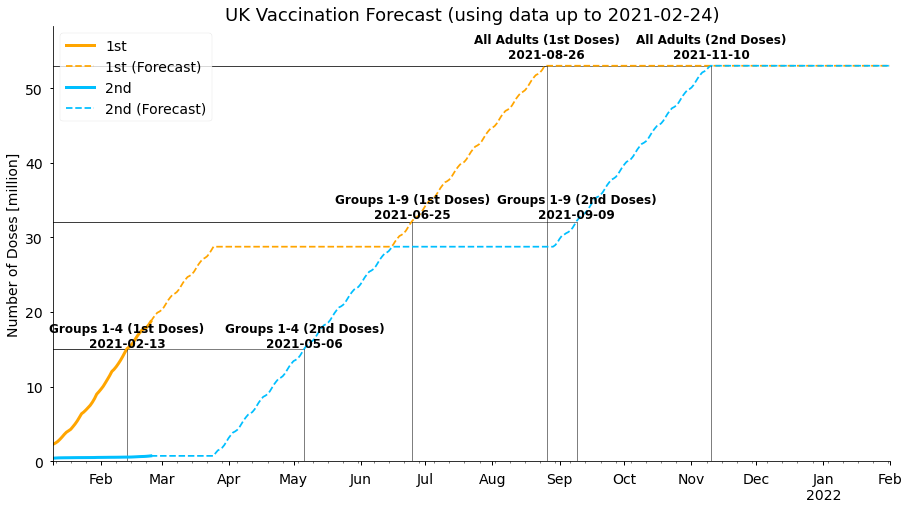

In [23]:
df_feb24 = forecast_vaccines(
    df[df.index <= datetime(2021, 2, 24)],
    second_dose_days,
    end_date=datetime(2022, 2, 1),
)
plot_cumulative_doses(
    df_feb24,
    forecast_date=datetime(2021, 2, 24),
    figsize=(15, 8), 
    title=f"UK Vaccination Forecast (using data up to {datetime(2021, 2, 24).date()})"
)

In the plot above, we see that in this forecast almost all adults are fully vaccinated by 20th August. However, before the remaining first doses can be given, a new batch of people requiring their second dose appear and must be given priority (without spare capacity for new first doses). 73 days later, on 1st November, the last few adults can start to be given their first dose. You'll notice that this 73 day delay in giving the last first doses is closely linked to the 72 day gap we assumed earlier between giving first doses and second doses. We can think of vaccines being given in alternating 72 day cycles of 1st doses and 2nd doses (at least in our simple forecast), and in the example above we have had to go through one additional cycle to complete the vaccination programme (compared to most forecasts which have completion datea in autumn 2021).

BUT
- assuming whole pop gets vaccinated etc.
- delay 2nd doses few days more in this case?